# Workers Profiling through Clustering Analysis

_Pablo Estrada, Fabricio Layedra, Galo Castillo & Carmen Vaca (2019)_

### Summary:
During the last five years, the _sharing economy_ has emerged as one of the main business models to offer goods and services. Human resource management is a key issue for sharing economy businesses. Our work aims to infer patterns regarding the performance of human resources in this context. We used unsupervised classification techniques over employee records from a delivery company that uses a sharing economy business model. We propose an automatic and scalable framework to discover efficient groups of workers, using features from logistic, geographical and temporal information. Although previous similar works have presented promising results, unlike them, we do not use demographic information about the employees. Our results suggest that deliveries per day, the kilometers covered by the worker and the companies that occupy a delivery agent are important features to determine outstanding workers. The framework proposed can turn into a key point to keep the exponential growth of these kind of companies during the time.

-------------------------


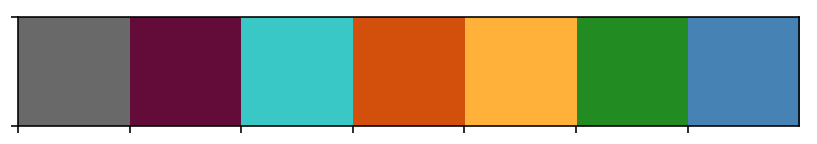

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=12)
plt.rcParams["figure.figsize"] = [9, 5]


#define a custom palette
customPalette = ['dimgrey', '#630C3A', '#39C8C6', '#D3500C', '#FFB139', 'forestgreen', 'steelblue']
sns.set_palette(customPalette)
sns.palplot(customPalette)

In [2]:
# Libraries for clustering analysis
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

- <a href='#1'>1. Loading & preparing data</a>
    - <a href='#1.1'>1.1 Reading data</a>
    - <a href='#1.2'>1.2 Cleaning and preparing features</a>
    
- <a href='#2'>2. Exploratory Data Analysis</a>
    
- <a href='#3'>3. Clustering Analysis</a>
    - <a href='#3.1'>3.1 K-Means</a>
    - <a href='#3.2'>3.2 HDBSCAN</a>
    - <a href='#3.3'>3.3 Clustering Visualization</a>

## <a id='1'>1. Loading & preparing data</a>

### <a id='1.1'>1.1 Reading data</a>

Reading shipper's features. Classified the features in temporal, spatial and logistic type. Each author focused in a specific type of feature.

In [3]:
# Features from task
df_task = pd.read_table('pablo_features_complete.txt', sep="\t")
df_task.tail()

,total_task,shipper_binned,shipper_id,distance_sum,distance_mean,distance_std,price_sum,price_mean,price_std,pricekm_sum,...,size_1,size_2,size_3,size_4,size_5,company_down,company_midlow,company_mid,company_midup,company_top
381,6,"(0, 12]",35191,57.7,9.616667,5.133972,38695.0,6449.166667,2620.469455,4661.986314,...,0.0,2.0,4.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0
382,19,"(12, 52]",35801,266.4,14.021053,1.479707,105581.0,5556.894737,3417.327707,7561.681163,...,0.0,14.0,3.0,2.0,0.0,0.0,0.0,19.0,0.0,0.0
383,19,"(12, 52]",35838,162.9,8.573684,2.181702,48488.0,2552.000000,197.489522,6143.857802,...,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
384,35,"(12, 52]",36206,327.9,9.368571,5.268652,112418.0,3211.942857,1371.588172,30745.614983,...,0.0,23.0,12.0,0.0,0.0,0.0,0.0,2.0,5.0,28.0
385,22,"(12, 52]",36231,213.8,9.718182,5.641904,79213.5,3600.613636,2638.379842,9815.927491,...,0.0,0.0,22.0,0.0,0.0,0.0,0.0,1.0,2.0,19.0


In [4]:
# Features from spatial data
df_spatial = pd.read_csv('geometrics_shippers_complete.csv')
df_spatial.tail()

,shipper_id,radius,coverage,entropy
381,19448,0.015719,1,0.138373
382,24571,0.070894,4,0.279351
383,32765,0.012732,2,0.154744
384,35838,0.059548,4,0.305784
385,6001,0.012305,2,0.120462


In [5]:
# Features from temporal data
df_temporal = pd.read_csv('shipper_temp_features.csv')
df_temporal.tail()

,shipper_id,total_days,worked_days,worked_days_ratio,mon_prob,tue_prob,wed_prob,thu_prob,fri_prob,sat_prob,sun_prob
381,35191,6.0,3.0,0.500000,0.000000,0.166667,0.333333,0.000000,0.500000,0.0,0.000000
382,35801,11.0,5.0,0.454545,0.157895,0.263158,0.105263,0.473684,0.000000,0.0,0.000000
383,35838,2.0,2.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000
384,36206,12.0,4.0,0.333333,0.000000,0.085714,0.000000,0.000000,0.771429,0.0,0.142857
385,36231,4.0,4.0,1.000000,0.045455,0.000000,0.136364,0.636364,0.136364,0.0,0.045455


In [6]:
# Merging features
df_shipper = pd.merge(df_task, df_spatial, on='shipper_id', how='left').merge(df_temporal, on='shipper_id')
df_shipper.tail().T

,381,382,383,384,385
total_task,6,19,19,35,22
shipper_binned,"(0, 12]","(12, 52]","(12, 52]","(12, 52]","(12, 52]"
shipper_id,35191,35801,35838,36206,36231
distance_sum,57.7,266.4,162.9,327.9,213.8
distance_mean,9.61667,14.0211,8.57368,9.36857,9.71818
distance_std,5.13397,1.47971,2.1817,5.26865,5.6419
price_sum,38695,105581,48488,112418,79213.5
price_mean,6449.17,5556.89,2552,3211.94,3600.61
price_std,2620.47,3417.33,197.49,1371.59,2638.38
pricekm_sum,4661.99,7561.68,6143.86,30745.6,9815.93


### <a id='1.2'>1.2 Cleaning and preparing features</a>

After several iterations that we do not show in this notebook, we keep the following features.

In [7]:
df_shipper.drop(['distance_sum', 'distance_std', 'price_mean', 'price_sum', 'price_std', 
                  'pricekm_mean', 'pricekm_sum', 'pricekm_std', 'mon_prob', 'tue_prob', 
                  'wed_prob', 'thu_prob', 'fri_prob', 'sat_prob', 'sun_prob'], axis='columns', inplace=True)
df_shipper.columns

Index(['total_task', 'shipper_binned', 'shipper_id', 'distance_mean', 'size_1',
       'size_2', 'size_3', 'size_4', 'size_5', 'company_down',
       'company_midlow', 'company_mid', 'company_midup', 'company_top',
       'radius', 'coverage', 'entropy', 'total_days', 'worked_days',
       'worked_days_ratio'],
      dtype='object')

Transforming the remaining features.

In [8]:
# Dropping some outliers
df_shipper['task_day'] = df_shipper['total_task'] / df_shipper['worked_days']

df_shipper = df_shipper[df_shipper['task_day']<50]

df_shipper = df_shipper[df_shipper['radius']<8]

# Porcentage of size and company shippings
percentage_list = ['size_1', 'size_2', 'size_3', 'size_4', 'size_5', 
                     'company_down', 'company_midlow', 'company_mid', 'company_midup', 'company_top']
for columna in percentage_list:
    df_shipper[columna] = df_shipper[columna].div(df_shipper['total_task'])


In [9]:
df_feat = df_shipper[['shipper_binned', 'task_day', 'distance_mean', #features from task
                      'size_1', 'size_2', 'size_3', 'size_4', 'size_5', #features for size of shipping
                      'company_down', 'company_midlow', 'company_mid', 'company_midup', 'company_top', #features from company 
                      'coverage', #'radius', 'entropy', #spacial fetures
                      'worked_days']]

df_feat = pd.get_dummies(df_feat, columns=['shipper_binned'])

# Scaling features
scaler2 = MinMaxScaler()
scaler1 = StandardScaler()

# Scaling each feature to a given range (0, 1)
df_feat[['task_day', 'distance_mean', 'coverage', 'worked_days']] = scaler2.fit_transform(df_feat[['task_day', 'distance_mean', 'coverage', 'worked_days']])

## <a id='2'>2 Exploratory Data Analysis</a>

We will focus on correlation and scatter plot

In [10]:
main_feat = ['task_day', 'distance_mean', 'coverage', 'size_3', 'company_top', 'worked_days']

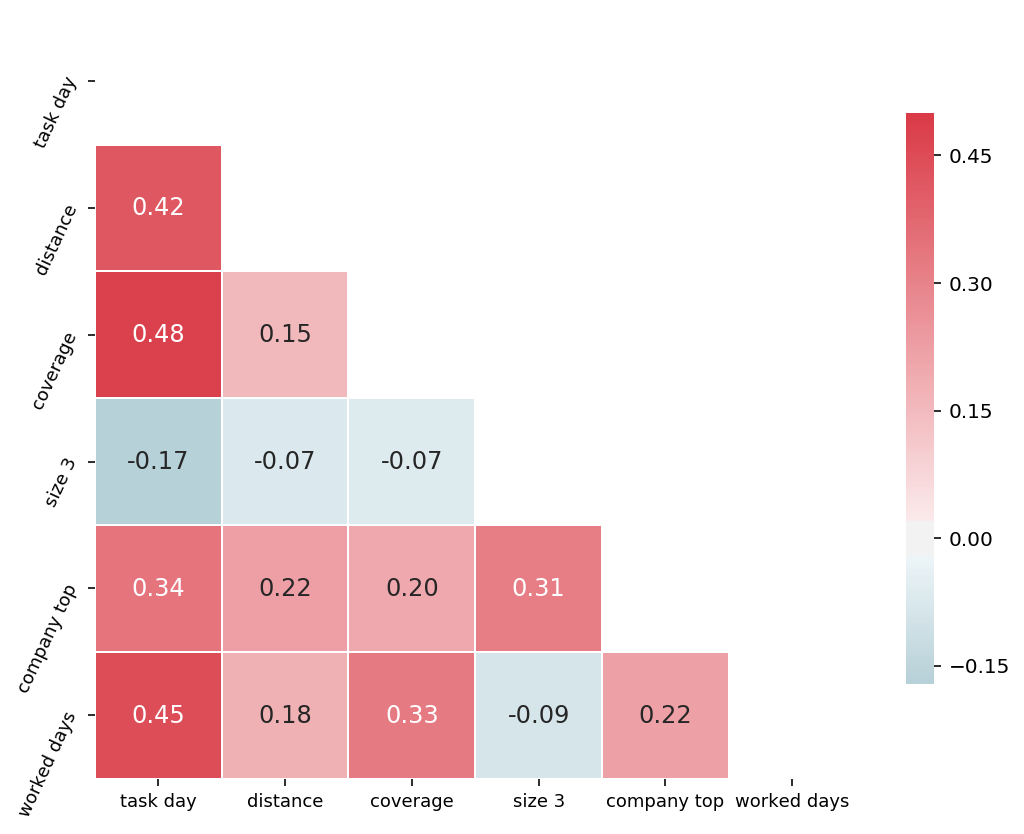

In [11]:
# Compute the correlation matrix
corr = df_feat[main_feat].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0, ax=ax, 
            annot=True, annot_kws={"size": 12}, fmt=".2f",
            square=True, linewidths=0.5, cbar_kws={"shrink": .75})
ax.set_yticklabels(['task day', 'distance', 'coverage', 'size 3', 'company top', 'worked days'], rotation=65, fontsize=9)
ax.set_xticklabels(['task day', 'distance', 'coverage', 'size 3', 'company top', 'worked days'], rotation=0, fontsize=9)

plt.show()
    
# plt.savefig('corr_plot.png', dpi=200, bbox_inches='tight')

## <a id='3'>3. Clustering Analysis</a>

Clustering is a Machine Learning technique that involves the grouping of data points. Given a set of data points, we can use a clustering algorithm to classify each data point into a specific group. In theory, data points that are in the same group should have similar properties and/or features, while data points in different groups should have highly dissimilar properties and/or features. 

Clustering is a method of unsupervised learning and is a common technique for statistical data analysis used in many fields.

In [12]:
# Funcion para correr diferentes algoritmos de clustering
def clusters(data, algorithm, args, kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    return labels

The __Silhouette Coefficient__ is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is $\frac{(b - a)}{max(a, b)}$

To clarify, $b$ is the distance between a sample and the nearest cluster that the sample is not a part of.
The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

### <a id='3.1'>3.1 K-Means</a>

The __KMeans__ algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

Source: [K-Means](http://scikit-learn.org/stable/modules/clustering.html#k-means)

In [13]:
data = df_feat

for n_clusters in range(2, 10):
    cluster_kmeans = clusters(data, cluster.KMeans, (), {'n_clusters': n_clusters})
    silhouette_avg = silhouette_score(data, cluster_kmeans)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is:", silhouette_avg)

For n_clusters = 2 The average silhouette_score is: 0.335513161669718
For n_clusters = 3 The average silhouette_score is: 0.4271299576846109
For n_clusters = 4 The average silhouette_score is: 0.489260342615147
For n_clusters = 5 The average silhouette_score is: 0.5081936442182956
For n_clusters = 6 The average silhouette_score is: 0.5425884259840305
For n_clusters = 7 The average silhouette_score is: 0.564325007033923
For n_clusters = 8 The average silhouette_score is: 0.5667770187268344
For n_clusters = 9 The average silhouette_score is: 0.5187105571559845


### <a id='3.2'>3.2 HDBSCAN</a>

HDBSCAN is a clustering algorithm developed by Campello, Moulavi, and Sander. It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters.

We can break it out into a series of steps:
1. Transform the space according to the density/sparsity.
2. Build the minimum spanning tree of the distance weighted graph.
3. Construct a cluster hierarchy of connected components.
4. Condense the cluster hierarchy based on minimum cluster size.
5. Extract the stable clusters from the condensed tree.

Source: [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)

Paper: [Campello R.J.G.B., Moulavi D., Sander J. (2013) Density-Based Clustering Based on Hierarchical Density Estimates.](https://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14)

**Selecting min_cluster_size**

The primary parameter to effect the resulting clustering is **min_cluster_size**. Ideally this is a relatively intuitive parameter to select – set it to the smallest size grouping that you wish to consider a cluster. Increasing the **min_cluster_size** to 30 reduces the number of clusters, merging some together.

In [14]:
data = df_feat

for n_clusters in range(2,20):
    cluster_hd = clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':n_clusters})
    silhouette_avg = silhouette_score(data, cluster_hd)
    print("For min_cluster_size =", n_clusters,
          "The average silhouette_score is:", silhouette_avg.round(2), 
          "And n_clusters:", np.unique(cluster_hd).size-1)

For min_cluster_size = 2 The average silhouette_score is: 0.31 And n_clusters: 29
For min_cluster_size = 3 The average silhouette_score is: 0.37 And n_clusters: 13
For min_cluster_size = 4 The average silhouette_score is: 0.39 And n_clusters: 11
For min_cluster_size = 5 The average silhouette_score is: 0.39 And n_clusters: 9
For min_cluster_size = 6 The average silhouette_score is: 0.39 And n_clusters: 9
For min_cluster_size = 7 The average silhouette_score is: 0.39 And n_clusters: 9
For min_cluster_size = 8 The average silhouette_score is: 0.38 And n_clusters: 9
For min_cluster_size = 9 The average silhouette_score is: 0.37 And n_clusters: 7
For min_cluster_size = 10 The average silhouette_score is: 0.37 And n_clusters: 7
For min_cluster_size = 11 The average silhouette_score is: 0.37 And n_clusters: 7
For min_cluster_size = 12 The average silhouette_score is: 0.37 And n_clusters: 7
For min_cluster_size = 13 The average silhouette_score is: 0.55 And n_clusters: 6
For min_cluster_size 

In [15]:
#Columna con label de clusters de K-Means
df_shipper['cluster_kmeans'] = clusters(df_feat, cluster.KMeans, (), {'n_clusters': 6})
df_shipper['cluster_kmeans'].value_counts().sort_index()

0     79
1     89
2    100
3     69
4     24
5     23
Name: cluster_kmeans, dtype: int64

In [16]:
#Columna con label de clusters de HDBSCAN
df_shipper['cluster_hdbscan'] = clusters(df_feat, hdbscan.HDBSCAN, (), {'min_cluster_size':13})
df_shipper['cluster_hdbscan'].value_counts().sort_index()

-1    56
 0    24
 1    23
 2    78
 3    87
 4    20
 5    96
Name: cluster_hdbscan, dtype: int64

### <a id='3.3'>3.3 Visualizing with t-SNE</a>

t-distributed Stochastic Neighbor Embedding is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

Source: [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

Paper: [van der Maaten, L.J.P.; Hinton, G.E. Visualizing High-Dimensional Data](http://www.jmlr.org/papers/v9/vandermaaten08a.html)

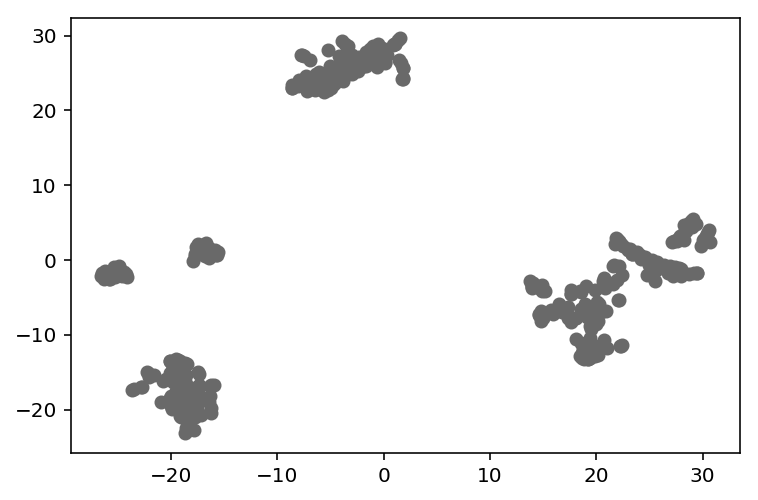

In [17]:
from sklearn.manifold import TSNE
data = df_feat
projection = TSNE().fit_transform(data)
plt.scatter(*projection.T)

In [18]:
# We use a dataframe to work better
clusterer = hdbscan.HDBSCAN(min_cluster_size=13).fit(data)
tsne = pd.DataFrame(projection)
tsne["label_hdbscan"] = clusterer.labels_
tsne = tsne.rename({0: "x", 1: "y"}, axis=1)

**HDBSCAN Clusters**

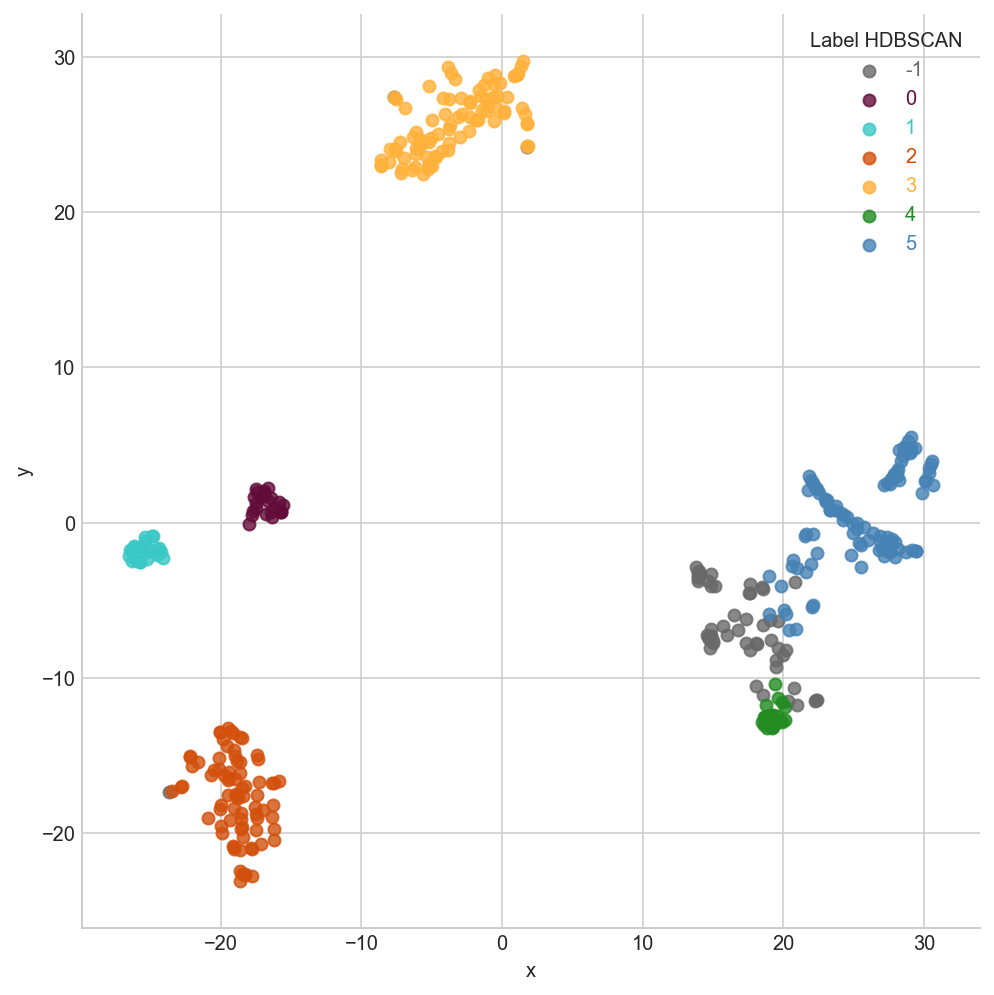

In [19]:
sns.set_style("whitegrid")

# plot data with seaborn
facet = sns.lmplot(data=tsne, x='x', y='y', hue="label_hdbscan", 
                   fit_reg=False, legend=False, legend_out=True, size=7)

# facet.fig.fig_size(20,15)

# add a legend
leg = facet.ax.legend(title="Label HDBSCAN", fancybox=True)

# change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])
    
# plt.savefig('cluster_hdbscan.png', dpi=200, bbox_inches='tight')

**K-Means Clusters **

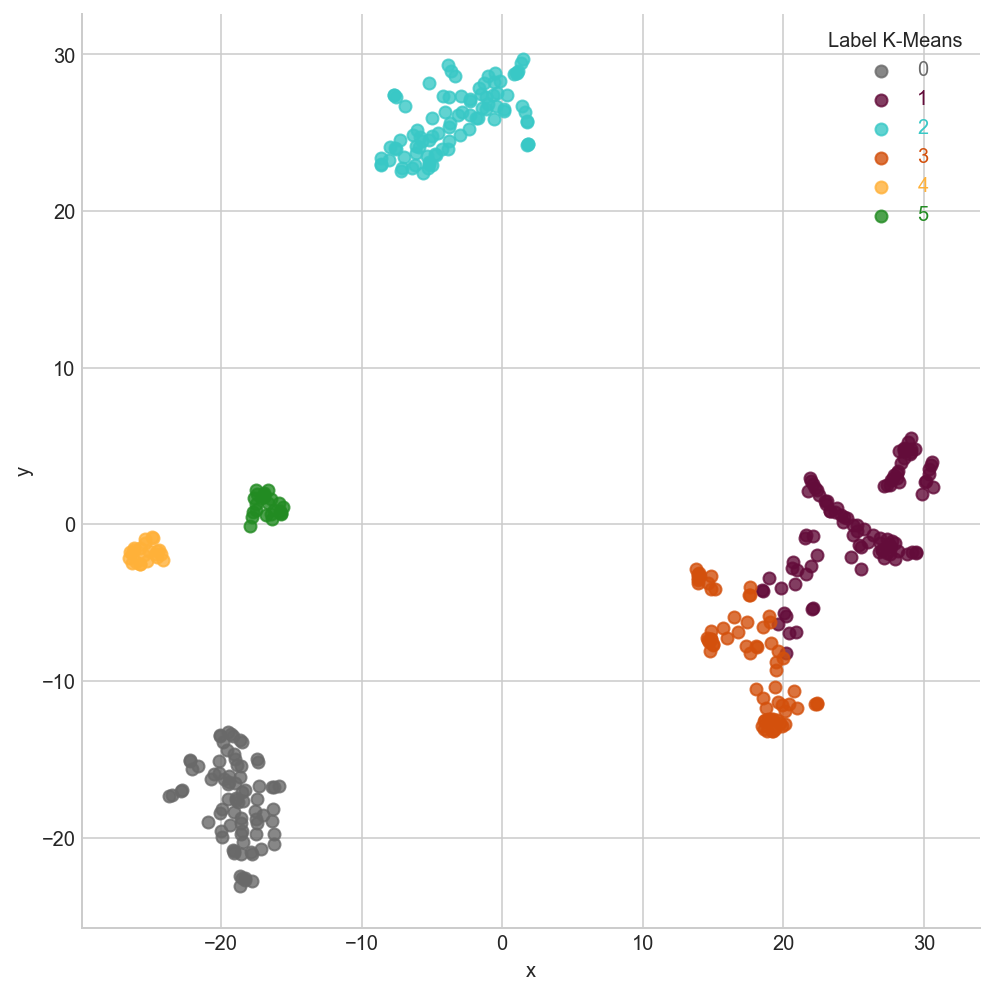

In [20]:
clusterer = clusters(data, cluster.KMeans, (), {'n_clusters': 6})
tsne["label_kmeans"] = clusterer

# plot data with seaborn
facet = sns.lmplot(data=tsne, x='x', y='y', hue="label_kmeans", 
                   fit_reg=False, legend=False, legend_out=True, size=7)

# facet.fig.fig_size(20,15)

# add a legend
leg = facet.ax.legend(title="Label K-Means", fancybox=True)

# change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])
    
# plt.savefig('cluster_kmeans.png', dpi=200, bbox_inches='tight')

In [21]:
# Creating results dataframe for hdbscan
df_hdbscan = df_shipper.groupby('cluster_hdbscan').mean()

# Principal features
df_hdbscan = df_hdbscan[main_feat]
df_hdbscan = df_hdbscan.apply(lambda x: x.round(2))

# Counting labels
df_count_hdbscan = df_shipper.groupby('cluster_hdbscan').count()[['shipper_id']]

# Merge both dataframes
df_hdbscan = pd.merge(df_count_hdbscan, df_hdbscan, left_index=True, right_index=True)

# Writing TeX file
with open("result_hdbscan.tex", 'w') as f:
    f.write(df_hdbscan.to_latex())

In [22]:
# Creating results dataframe for k-means
df_kmeans = df_shipper.groupby('cluster_kmeans').mean()

# Principal features
df_kmeans = df_kmeans[main_feat]
df_kmeans = df_kmeans.apply(lambda x: x.round(2))

# Counting labels
df_count_kmeans = df_shipper.groupby('cluster_kmeans').count()[['shipper_id']]

# Merge both dataframes
df_kmeans = pd.merge(df_count_kmeans, df_kmeans, left_index=True, right_index=True)

# Writing TeX file
with open("result_kmeans.tex", 'w') as f:
    f.write(df_kmeans.to_latex())

In [23]:
df_shipper.groupby('cluster_hdbscan').mean().drop('shipper_id', axis='columns').apply(lambda x: x.round(2))[['size_1', 'size_2', 'size_3', 'size_4', 'size_5']]

,size_1,size_2,size_3,size_4,size_5
cluster_hdbscan,,,,,
-1,0.06,0.35,0.58,0.02,0.00
0,0.03,0.15,0.82,0.00,0.00
1,0.04,0.24,0.71,0.01,0.00
2,0.02,0.06,0.91,0.01,0.00
3,0.03,0.07,0.88,0.02,0.01
4,0.00,0.03,0.97,0.00,0.00
5,0.00,0.01,0.98,0.00,0.00


In [24]:
df_shipper.groupby('cluster_hdbscan').agg(['mean', 'std']).drop('shipper_id', axis='columns').apply(lambda x: x.round(2))[['company_down', 'company_midlow', 'company_mid', 'company_midup', 'company_top']]

company_down       company_midlow       company_mid        \
                        mean   std           mean   std        mean   std   
cluster_hdbscan                                                             
-1                      0.01  0.07           0.05  0.17        0.51  0.39   
 0                      0.00  0.00           0.00  0.00        0.03  0.04   
 1                      0.00  0.00           0.00  0.00        0.02  0.02   
 2                      0.00  0.01           0.01  0.05        0.08  0.07   
 3                      0.00  0.01           0.01  0.03        0.12  0.21   
 4                      0.00  0.00           0.00  0.00        0.02  0.06   
 5                      0.00  0.02           0.00  0.02        0.02  0.06   

                company_midup       company_top        
                         mean   std        mean   std  
cluster_hdbscan                                        
-1                       0.23  0.31        0.20  0.27  
 0                       0.04  0.04        0.93  0.08  
 1                       0.03  0.03        0.95  0.05  
 2                       0.13  0.14        0.77  0.21  
 3                       0.22  0.25        0.65  0.30  
 4                       0.95  0.10        0.03  0.09  
 5                       0.03  0.08        0.95  0.11

In [25]:
df_shipper.groupby('cluster_hdbscan').agg(['mean', 'std']).drop('shipper_id', axis='columns').apply(lambda x: x.round(2))[['total_days', 'worked_days', 'worked_days_ratio']]

total_days        worked_days        worked_days_ratio      
                      mean    std        mean    std              mean   std
cluster_hdbscan                                                             
-1                   24.80  60.67        2.54   1.56              0.63  0.39
 0                  161.25  99.19       48.33  27.01              0.35  0.17
 1                  267.30  87.82      100.83  47.53              0.41  0.19
 2                  107.82  88.08       22.62  18.88              0.31  0.19
 3                   72.80  86.50        6.67   3.97              0.28  0.28
 4                   14.45  39.99        1.50   1.00              0.78  0.38
 5                   13.08  27.21        1.76   1.16              0.77  0.38

In [26]:
# This imports an attractive notebook style from Github
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('http://bit.ly/1Bf5Hft').read().decode('UTF-8'))